In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import svd, lstsq, eigh

%matplotlib inline

In [20]:
video_path = "/Users/ainee_f/Documents/school_docs/computer_vision/video.mp4" 

cap = cv2.VideoCapture(video_path)
frames = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frames.append(gray)

cap.release()
print("Loaded", len(frames), "frames.")

Loaded 146 frames.


In [21]:
# detect features in frame 0
# we use a feature tracker to capture relevant features (corners, etc)
p0 = cv2.goodFeaturesToTrack(frames[0],
                             maxCorners=200,
                             qualityLevel=0.01,
                             minDistance=7,
                             blockSize=7)

# prepare a list of "tracks" to store positions of the corner in succeeding
# frames
tracks = [[] for _ in range(len(p0))]
p_prev = p0

# loop through all the frames to find movement of corners using LK algorithm
for f in range(len(frames)-1):
    p_next, st, err = cv2.calcOpticalFlowPyrLK(frames[f], frames[f+1], p_prev, None)

    good_prev = p_prev[st == 1]
    good_next = p_next[st == 1]

    j = 0
    for i in range(len(p_prev)):
        if st[i] == 1:
            tracks[i].append(good_next[j])
            j += 1

    p_prev = p_next

# here we keep only the clean tracks after iterating through each frame
full_tracks = [np.array(t) for t in tracks if len(t) == len(frames)-1]
full_tracks = np.array(full_tracks)  # shape: (P, F-1, 2)

print("Good tracks:", full_tracks.shape)

Good tracks: (62, 145, 2)


In [22]:
# here we turn the detected tracks into the measurement matrix W
# (core input into the Tomasi-Kanade method)


# reshape tracks to (F, P, 2)
full_tracks = np.transpose(full_tracks, (1,0,2))
F, P, _ = full_tracks.shape

# initialize a matrix in the correct shape
W = np.zeros((2*F, P))

# iterate through each frame and update the W matrix
for f in range(F):
    xs = full_tracks[f,:,0]
    ys = full_tracks[f,:,1]

    xs -= xs.mean()
    ys -= ys.mean()

    W[2*f,:]   = xs
    W[2*f+1,:] = ys

print("W shape:", W.shape)

W shape: (290, 62)


In [23]:
# full_matrices=False equivalent = no overwrite

# here we do SVD factorization to get U, s, and VT from W
U, s, VT = svd(W, full_matrices=False)

# we use U, s and VT to find M0 and S0 which represents 
# the initial motion matrix (M0) and the initial structure matrix (3D points detected)
U1 = U[:, :3]
Sigma1 = np.diag(s[:3])
V1 = VT[:3, :]

Sigma1_sqrt = np.sqrt(Sigma1)

M0 = U1 @ Sigma1_sqrt
S0 = Sigma1_sqrt @ V1

print("M0:", M0.shape)
print("S0:", S0.shape)

M0: (290, 3)
S0: (3, 62)


In [24]:
# in this stage the 'metric upgrade' is done where the uncalibrated W matrix
# is converted to a physically meaningful structure and motion pair

# this is done because there is still some ambiguity with M0 and S0 matrices

# given a 3D row vector (x, y, z), this parts generates quadractic coefficients
# for the linear equations that enforce norm contraints

def g(r):
    x, y, z = r
    return np.array([x*x, 2*x*y, y*y, 2*x*z, 2*y*z, z*z])

# here defines orthogonality constraints
def h(r1, r2):
    x1,y1,z1 = r1
    x2,y2,z2 = r2
    return np.array([
        x1*x2,
        x1*y2 + x2*y1,
        y1*y2,
        x1*z2 + x2*z1,
        y1*z2 + y2*z1,
        z1*z2
    ])

# initialize A and b
A = []
b = []

# loop over each frame and extract camera rows
for f in range(F):
    m1 = M0[2*f]
    m2 = M0[2*f + 1]

    # add normalization constraints to each matrix
    A.append(g(m1));  b.append(1.0)
    A.append(g(m2));  b.append(1.0)
    A.append(h(m1,m2)); b.append(0.0)

# convert lists to arrays
A = np.array(A)
b = np.array(b)

print("A shape:", A.shape)

A shape: (435, 6)


In [25]:
# the linear system is solved in this section,
# the matrix L is constructed

ell, _, _, _ = lstsq(A, b)

l1,l2,l3,l4,l5,l6 = ell
L = np.array([
    [l1, l2, l4],
    [l2, l3, l5],
    [l4, l5, l6]
])

print("L =\n", L)

L =
 [[ 7.41968662e-03 -6.12772886e-06  4.27334565e-04]
 [-6.12772886e-06  2.19349473e-02 -1.51519457e-03]
 [ 4.27334565e-04 -1.51519457e-03  5.94367867e-04]]


In [26]:
# here we take the square too of L via Eigen Decomposition and ensure that values below 0 are
# removed to avoid numerical problems

eigvals, eigvecs = eigh(L)

# ensure non-negative
eigvals[eigvals < 0] = 0

Q = eigvecs @ np.diag(np.sqrt(eigvals))

print("Q =\n", Q)

Q =
 [[-0.00131191  0.08612683 -0.00036804]
 [ 0.00150848  0.00058467  0.14809568]
 [ 0.02138382  0.00524267 -0.0104697 ]]


In [27]:
Qinv = np.linalg.inv(Q)

M = M0 @ Q
S = Qinv @ S0

print("Final M:", M.shape)
print("Final S:", S.shape)

Final M: (290, 3)
Final S: (3, 62)


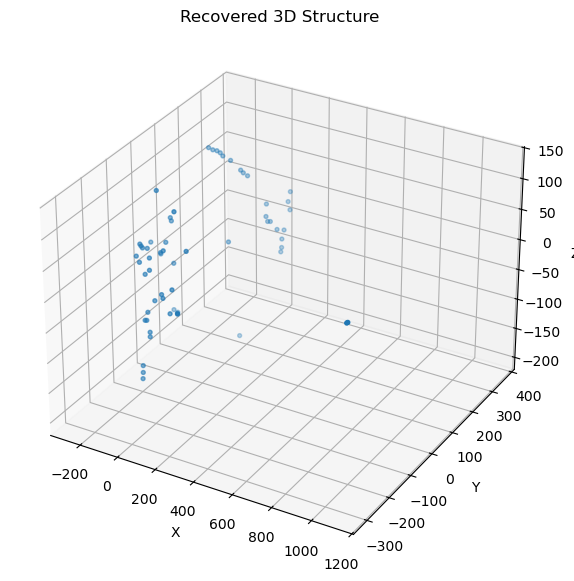

In [28]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(S[0,:], S[1,:], S[2,:], s=8)

ax.set_title("Recovered 3D Structure")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.show()